In [1]:
import os
import random
import numpy as np
import tensorflow as tf
seed = 1
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [2]:
import tensorflow_hub as hub
import tensorflow_addons as tfa
import tensorflow_text as tf_text
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras.layers import Input, Dense, Conv1D, GlobalMaxPooling1D

In [3]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [4]:
def build_model():
  
    model = Sequential()
    model.add(Input(shape= (128, 768)))
    model.add(Conv1D(32, 5, activation ='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(6, activation ='softmax'))
    return model

In [5]:
def get_embedding(questions):
    
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
    preprocess_path = "D:/bert_models/bert_en_uncased_preprocess_3"
    bert_path = "D:/bert_models/bert_en_uncased_L-12_H-768_A-12_4"
    preprocess_model = hub.KerasLayer(preprocess_path)    
    encoder = hub.KerasLayer(bert_path)
    
    encoder_inputs = preprocess_model(text_input)
    outputs = encoder(encoder_inputs)["sequence_output"] 

    embedding_model = tf.keras.Model(text_input, outputs)
    embeddings = embedding_model(tf.constant(questions))

    return embeddings

In [6]:
def evaluate_model(model, X_test, y_test):
    pred = model.predict(X_test)
    predicted_classes = np.argmax(pred, axis = 1)
    true_classes = np.argmax(y_test, axis = 1)
    accuracy = accuracy_score(true_classes, predicted_classes)
    print(f"Accuracy: {accuracy}")
    f1_ = f1_score(true_classes, predicted_classes, average = 'weighted')
    print(f"F1 score: {f1_}")
    print(classification_report(true_classes, predicted_classes))

In [7]:
def plot_result(log_data): 
    plt.figure(figsize=(10, 6))
    plt.plot(log_data['loss'], label ='train')
    plt.plot(log_data['val_loss'], label ='test')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.figure(figsize=(10, 6))
    plt.plot(log_data['accuracy'], label ='train')
    plt.plot(log_data['val_accuracy'], label ='test')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(10, 6))
    plt.plot(log_data['f1_score'], label ='train')
    plt.plot(log_data['val_f1_score'], label ='test')
    plt.title('Model F1 Score')
    plt.ylabel('F1 Score')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

In [8]:
questions = pd.read_csv('data/combined_dataset.csv')
questions

,QUESTION,BT LEVEL
0,"Suppose prices of two goods are constant, expl...",Comprehension
1,Explain the concept of price leadership observ...,Comprehension
2,Define profit. Briefly explain how accounting ...,Comprehension
3,Describe the assumptions of monopolistic compe...,Comprehension
4,Explain the meaning of the law of diminishing ...,Comprehension
...,...,...
2517,PEST and SWOT are popular strategy tools. Disc...,Application
2518,List the advantages and disadvantages of Publi...,Knowledge
2519,Show your calculations for all THREE (3) optio...,Analysis
2520,Currently the product life cycle for Apple iPo...,Evaluation


In [9]:
X = questions['QUESTION']
cognitive_level = {"Knowledge": 0, "Comprehension": 1, "Application": 2, "Analysis": 3, "Synthesis": 4, "Evaluation": 5}
questions["BT LEVEL"].replace(cognitive_level, inplace = True)
y = questions['BT LEVEL'].values

In [10]:
X_train, X_test, y_train, y_test  = train_test_split(X, y , test_size = 0.10, stratify = questions['BT LEVEL'], 
                                                                             shuffle = True, random_state = 1)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [11]:
X_train.shape

(2269,)

In [12]:
X_train_bert_base = get_embedding(X_train)
X_test_bert_base = get_embedding(X_test)

In [13]:
np.save('embedding/bert/embeddings-train.npy', X_train_bert_base)
np.save('embedding/bert/embeddings-test.npy', X_test_bert_base)

In [14]:
X_train_bert_base = np.load('embedding/bert/embeddings-train.npy')
X_test_bert_base = np.load('embedding/bert/embeddings-test.npy')

In [15]:
#model
model = build_model()
# compiling the model
model.compile(optimizer = 'RMSprop', loss='categorical_crossentropy', metrics= ['accuracy', tfa.metrics.F1Score(6, 'weighted')])
# printing summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 124, 32)           122912    
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 6)                 198       
                                                                 
Total params: 123,110
Trainable params: 123,110
Non-trainable params: 0
_________________________________________________________________


In [16]:
training_logger = CSVLogger('log/Bert/base/training.log', separator = ',', append = False)

In [17]:
# fit the model
model.fit(X_train_bert_base, y_train, epochs = 50, batch_size = 8, validation_data = (X_test_bert_base, y_test),
                                                  callbacks = [training_logger], verbose = 1)
#saving the trained model
model.save('saved_models/Bert/base/EQCM.h5')

Epoch 1/50
284/284 [==============================] - 38s 64ms/step - loss: 1.1712 - accuracy: 0.5809 - f1_score: 0.5749 - val_loss: 0.9329 - val_accuracy: 0.6877 - val_f1_score: 0.6736
Epoch 2/50
284/284 [==============================] - 15s 53ms/step - loss: 0.6153 - accuracy: 0.7911 - f1_score: 0.7902 - val_loss: 1.1111 - val_accuracy: 0.6443 - val_f1_score: 0.6434
Epoch 3/50
284/284 [==============================] - 14s 50ms/step - loss: 0.3739 - accuracy: 0.8682 - f1_score: 0.8680 - val_loss: 0.8399 - val_accuracy: 0.7391 - val_f1_score: 0.7302
Epoch 4/50
284/284 [==============================] - 15s 52ms/step - loss: 0.2237 - accuracy: 0.9238 - f1_score: 0.9237 - val_loss: 1.1002 - val_accuracy: 0.6680 - val_f1_score: 0.6794
Epoch 5/50
284/284 [==============================] - 13s 45ms/step - loss: 0.1331 - accuracy: 0.9625 - f1_score: 0.9625 - val_loss: 1.0896 - val_accuracy: 0.7194 - val_f1_score: 0.7126
Epoch 6/50
284/284 [==============================] - 12s 44ms/step - 

In [18]:
log_data = pd.read_csv('log/Bert/base/training.log', sep = ',', engine = 'python')
log_data.head(50)

,epoch,accuracy,f1_score,loss,val_accuracy,val_f1_score,val_loss
0,0,0.580873,0.574887,1.171206e+00,0.687747,0.673577,0.932945
1,1,0.791097,0.790179,6.152576e-01,0.644269,0.643390,1.111133
2,2,0.868224,0.867981,3.738970e-01,0.739130,0.730171,0.839865
3,3,0.923755,0.923674,2.237257e-01,0.667984,0.679425,1.100209
4,4,0.962539,0.962517,1.330864e-01,0.719368,0.712613,1.089584
5,5,0.975760,0.975768,7.503555e-02,0.770751,0.771852,0.951226
6,6,0.983253,0.983246,5.490227e-02,0.743083,0.740395,1.074639
7,7,0.991626,0.991624,2.806706e-02,0.758893,0.750055,1.123522
8,8,0.993830,0.993830,2.165421e-02,0.798419,0.798592,1.005618
9,9,0.996474,0.996475,1.413944e-02,0.758893,0.754771,1.215966


In [19]:
model.load_weights("saved_models/Bert/base/EQCM.h5")
evaluate_model(model, X_test_bert_base, y_test)

8/8 [==============================] - 1s 26ms/step
Accuracy: 0.7747035573122529
F1 score: 0.7700291141257514
              precision    recall  f1-score   support

           0       0.81      0.74      0.78        35
           1       0.78      0.88      0.82        96
           2       0.67      0.50      0.57        32
           3       0.80      0.80      0.80        30
           4       0.73      0.86      0.79        28
           5       0.85      0.69      0.76        32

    accuracy                           0.77       253
   macro avg       0.77      0.74      0.75       253
weighted avg       0.77      0.77      0.77       253



In [20]:
log_data['val_accuracy'].describe()

count    50.000000
mean      0.761186
std       0.029254
min       0.644269
25%       0.751976
50%       0.770751
75%       0.774704
max       0.798419
Name: val_accuracy, dtype: float64

In [21]:
log_data['val_f1_score'].describe()

count    50.000000
mean      0.756483
std       0.028740
min       0.643390
25%       0.747237
50%       0.765121
75%       0.771847
max       0.798592
Name: val_f1_score, dtype: float64

In [22]:
log_data[['val_accuracy']].idxmax() + 1

val_accuracy    9
dtype: int64

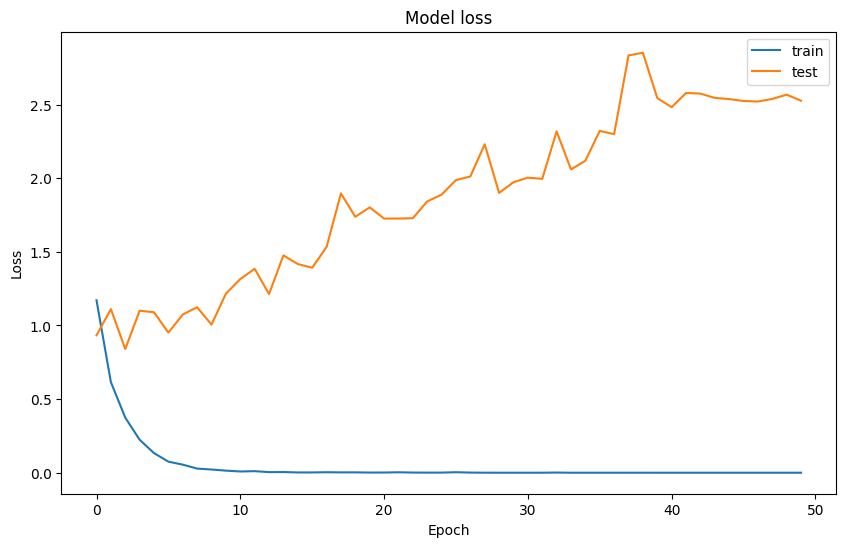

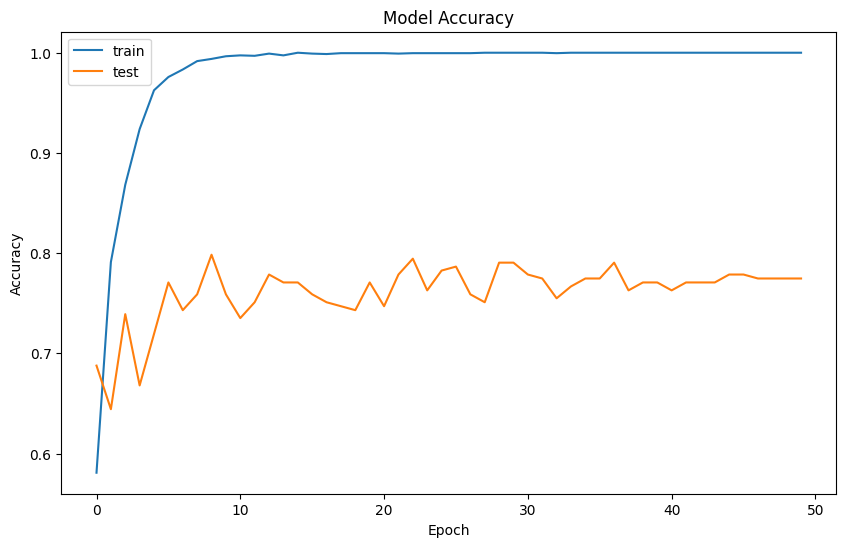

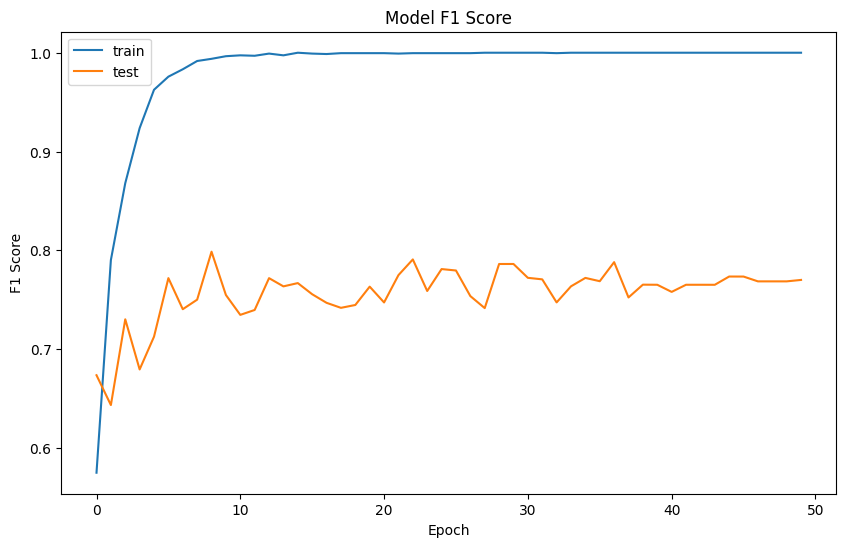

In [23]:
plot_result(log_data)

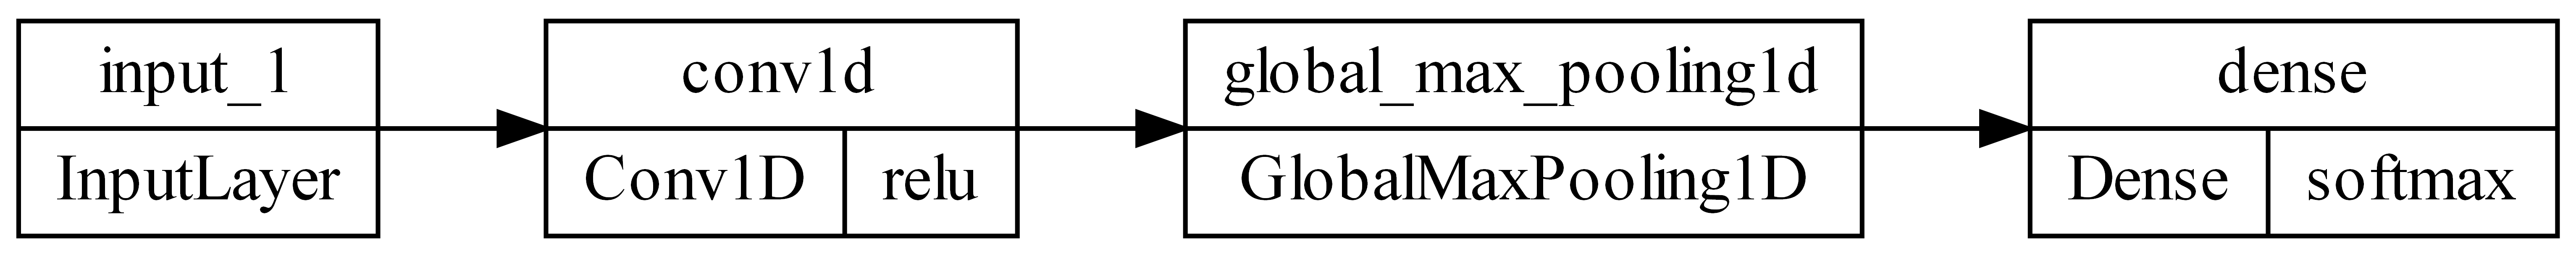

In [24]:
plot_model(model, to_file = 'visualization/contextual_model.png', show_shapes = False, show_layer_activations = True, dpi = 800, rankdir = 'LR')